In [2]:
# imPORT LIBRARIES 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import pi, sqrt
import handcalcs.render
import pandas as pd
import json 
# !pip install handcalcs

In [3]:
# CONFIGURATIONS
#help(handcalcs.set_option)
handcalcs.set_option("latex_block_start", "$")
handcalcs.set_option("latex_block_end", "$")
handcalcs.set_option("math_environment_end", "aligned")
handcalcs.set_option("use_scientific_notation",True)

In [4]:
from localcode import *
fig_counter=1

# Resonance Tank Capacitor and Output Capacitor

## Inputs and claculated parameters

In [5]:
with open("../01_llc_tank/04_outputs/inp_datas.json", "r", encoding="utf-8") as f:
    inp_datas = json.load(f)
#print("Input datas:")
#print("="*20)
#display(inp_datas)
S= pd.Series(inp_datas, name = "Input datas").to_frame()
display(S)

with open("../01_llc_tank/04_outputs/out_results.json", "r", encoding="utf-8") as f:
    out_datas = json.load(f)
#print("Output datas:")
#print("="*20)
#display(out_datas)

S= pd.Series(out_datas, name = "Output datas").to_frame()
display(S)


# Load variables 
for key, value in inp_datas.items():
    globals()[key] = value
for key, value in out_datas.items():
    globals()[key] = value

,Input datas
V_In_min,360.0
V_In_nom,380.0
V_In_max,400.0
Vo_min,42.0
Vo_nom,48.0
Vo_max,54.0
Power,1200.0
f_nom,100000.0


,Output datas
Lnc,3.000000e+00
Qec,5.500000e-01
Cr_nF,1.162090e+02
n,4.000000e+00
Lr_uH,2.179700e+01
Lm_uH,6.539200e+01
fsw_min,6.017000e+04
fsw_max,1.562200e+05
Im_rms,6.992000e+00
Io,2.500000e+01


## Output capacitor Co

### Formulas

For a resistive load, the output capacitor is determined by
$$
C_o \geq C_{o_{min}} = \frac{I_o}{8 \cdot f_{sw} \cdot \Delta V_{out}}
$$

Where:

- $C_o$ : Output capacitance (Farads, F)  
- $I_o$ : Output load current (Amperes, A)  
- $f_{sw}$ : Switching frequency of the converter (Hertz, Hz)  
- $\Delta V_{out}$ : Maximum allowed output voltage ripple (Volts, V)  
$$ESR_{max} = \frac{\Delta V_{out}}{I_{rect\_peak}} = \frac{\Delta V_{out}}{\frac{\pi}{4} \cdot I_o\cdot{2}}  $$
$$I_{C_o} = I_o \sqrt{\frac{\pi^2}{8} - 1}$$

Where:

- $I_{C_o}$ : RMS current of the capacitor @ f_sw = f_nom  
 
See page 26, 27 [\[1\]](#referencesID_03_1).
<br> By default, you can found all formula of this chapeter in the same ref 

### Numerical Implementation of the Formulas

**We must use fsw_min to the worst case**

In [6]:
%%render
Io # A
fsw_min # Hz
DV = 0.25 # vpp
Co_min_uF = 1e6*Io/(8*fsw_min*DV ) # uF
ESR_max_m = 1e3*DV /(Io*pi/2) # mΩ 
I_Co= Io*sqrt(pi**2/8-1) # Arms

<IPython.core.display.Latex object>

### First proposition

B40910A8127M000 aluminum electrolytic capacitors with Temp_max = 150°C, Below a screenshoot of the datasheet [\[2\]](#referencesID_03_2).

In [7]:
first_part_path = "./03_figures/"

fig_counter = show_figure_pair_with_captions(
    fig_counter, 
    "B40910.png",
    "VRMS",
    first_part_path= first_part_path, 
)

Let's start with a configuration of 5 capacitors in parallel

In [8]:
%%render 
#4 parallels capascitor
Nb_capa= 5
C_capa_nom = 120 # uF
Margin = 20 #\%
C_capa = C_capa_nom*(1-Margin/100)# uF, Worst case 
C_eq = C_capa*Nb_capa # uF > 208uF ok
ESR_capa= 17 # Ω @ 100kHz

ESR_eq = ESR_capa/Nb_capa # Ω < 6.36m OK
Icapa_max = 4.6
Ieq_max = Icapa_max *Nb_capa  #  @ Arms @ 125°C 100kHz > 12.08Arms ok

<IPython.core.display.Latex object>

**Voltage ripples**

In [9]:
%%render 
Delta_V_out = Io/(8*fsw_min*C_eq*1e-6 )

<IPython.core.display.Latex object>

#### Self heating

**Power Dissipation of Each Capacitor**

In [10]:
%%render 
I_each_capa= I_Co/Nb_capa
P_selfHeating = ESR_capa*1e-3*I_each_capa**2 # W

<IPython.core.display.Latex object>

**Estimation of Thermal Resistance Rth**

In [11]:
%%render 
# Estimation or Rth 

# @100Khz and 125°C Iac,R I=4.6A
# 100KHZ 20°C ESR = 0.017 Ohm 
# Max T = 150°C 
Delta_T= 150-125 # °C
ESR = 17e-3
I = 4.6 # Arms
P_dissip= ESR*I**2 # W
R_th = Delta_T/P_dissip # °C/W

<IPython.core.display.Latex object>

**The self heating estimation and the max ambiant temp**

In [12]:
%%render 
# self heating 
Delta_T= P_selfHeating*R_th # °C => low delta temp
Margin = 30 # °C 
T_max = 150
T_amb_max = T_max -Delta_T-Margin  # °C 

<IPython.core.display.Latex object>

**Voltage margin**

In [13]:
%%render  
Vo_max # VDC
V_max_datasheet = 63 # VDC
Voltage_Margin =  100*(V_max_datasheet-Vo_max) /V_max_datasheet # \%

<IPython.core.display.Latex object>

This solution is acceptable, but the voltage margin is limited.

In [14]:
dic_capa1= {}
for x in "C_capa,ESR_eq,C_eq,Ieq_max,Nb_capa,P_selfHeating,T_amb_max,Voltage_Margin,Delta_V_out".split(","):
    dic_capa1[x]= eval(x)

### Second proposition

EMHS101ARA331MMN0S aluminum electrolytic capacitors with Temp_max = 150°C, Below a screenshoot of the datasheet [\[4\]](#referencesID_03_4).

In [15]:
first_part_path = "./03_figures/"

fig_counter = show_figure_pair_with_captions(
    fig_counter, 
    "EMHS.png",
    "VRMS" , 
    first_part_path= first_part_path, 
)

Let's start with a configuration of 5 capacitors in parallel

In [16]:
%%render 
#4 parallels capascitor
Nb_capa= 10
C_capa_nom = 330 # uF
Margin = 20 #\%
C_capa = C_capa_nom*(1-Margin/100)# uF, Worst case 
C_eq = C_capa*Nb_capa # uF > 208uF ok
ESR_capa= 59 # Ω @ 100kHz

ESR_eq = ESR_capa/Nb_capa # Ω < 6.36m OK
Icapa_max = 2.3
Ieq_max = Icapa_max *Nb_capa  #  @ Arms @ 125°C 100kHz > 12.08Arms ok

<IPython.core.display.Latex object>

**Voltage ripples**

In [17]:
%%render 
Delta_V_out = Io/(8*fsw_min*C_eq*1e-6 )

<IPython.core.display.Latex object>

#### Self heating

**Power Dissipation of Each Capacitor**

In [18]:
%%render 
I_each_capa= I_Co/Nb_capa
P_selfHeating = ESR_capa*1e-3*I_each_capa**2 # W

<IPython.core.display.Latex object>

**Estimation of Thermal Resistance Rth**

In [19]:
%%render 
# Estimation or Rth 

# @100Khz and 125°C Iac,R I=4.6A
# 100KHZ 20°C ESR = 0.017 Ohm 
# Max T = 150°C 
Delta_T= 150-125 # °C
P_dissip= ESR_capa*1e-3*Icapa_max **2 # W
R_th = Delta_T/P_dissip # °C/W

<IPython.core.display.Latex object>

**The self heating estimation and the max ambiant temp**

In [20]:
%%render 
# self heating 
Delta_T= P_selfHeating*R_th # °C => low delta temp
Margin = 30 # °C 
T_max = 150
T_amb_max = T_max -Delta_T-Margin  # °C 

<IPython.core.display.Latex object>

In [21]:
%%render  
Vo_max # VDC
V_max_datasheet = 100 # VDC
Voltage_Margin =  100*(V_max_datasheet-Vo_max) /V_max_datasheet # \%

<IPython.core.display.Latex object>

In [22]:
dic_capa2= {}
for x in "C_capa,ESR_eq,C_eq,Ieq_max,Nb_capa,P_selfHeating,T_amb_max,Voltage_Margin,Delta_V_out".split(","):
    dic_capa2[x]= eval(x)

### Comparaison

In [23]:
dic_capa1["VmaxDC"]=63
dic_capa2["VmaxDC"]=100

In [24]:
requirements= {"ESR_eq":ESR_max_m, "C_eq":Co_min_uF, "Ieq_max":I_Co, 
               "VmaxDC":Vo_max, "Delta_V_out":DV}

In [25]:
pd.DataFrame([requirements, dic_capa1, dic_capa2], 
             index= ["requirements","Solutio1", "Solutio2"]).T.round(2)

,requirements,Solutio1,Solutio2
ESR_eq,6.37,3.40,5.90
C_eq,207.74,480.00,2640.00
Ieq_max,12.09,23.00,23.00
VmaxDC,54.00,63.00,100.00
Delta_V_out,0.25,0.11,0.02
C_capa,NaN,96.00,264.00
Nb_capa,NaN,5.00,10.00
P_selfHeating,NaN,0.10,0.09
T_amb_max,NaN,113.10,113.10
Voltage_Margin,NaN,14.29,46.00


The margin in the first solution is limited (16% in the worst case). However, I propose we proceed with this option, given the number of parallel capacitors. Care must be taken in control to prevent any overshoot or transient voltage, especially when Vout is at Vout_max.

## Transformer design

In [26]:
params = ['n',  'Lm_uH', 'fsw_min', 'fsw_max', 'Ir_rms', 'Im_rms', 'Ioe_rms', 'Ios_rms', 'L_second_uH']

dic_transfo= {x:out_datas[x] for x in params}
Al = out_datas["Lm_uH"]/out_datas["n"]**2
dic_transfo["Al_uH"]= Al
print("Transormer parameters:")
display(dic_transfo)

Transormer parameters:


{'n': 4.0,
 'Lm_uH': 65.392,
 'fsw_min': 60170.0,
 'fsw_max': 156220.0,
 'Ir_rms': 10.354,
 'Im_rms': 6.992,
 'Ioe_rms': 7.636,
 'Ios_rms': 30.545,
 'L_second_uH': 4.087,
 'Al_uH': 4.087}

where: 
* `n`: Transformer turns ratio $ n = N_p / N_s $
* `N_p = n` since `N_s= 1`
* `Lm_uH`: Magnetizing inductance $ L_m $, sets magnetizing current and contributes to gain shaping
* `fsw_min`: Minimum switching frequency $ f_{sw,\min} $, corresponds to maximum load
* `fsw_max`: Maximum switching frequency $ f_{sw,\max} $, corresponds to no-load
* `Ir_rms`: RMS current in the resonant tank inductor $ I_r = \sqrt{I_m^2 + I_{oe}^2} $
* `Im_rms`: RMS magnetizing current $ I_m $, flows through $ L_m $
* `Ioe_rms`: RMS transferred current in the primary winding, represents reflected load current
* `Ios_rms`: RMS current in the secondary winding $ I_{os} = I_{oe} \cdot n $
* `Al_uH`: Inductance per turn squared $ A_L $, used to compute turns: $ L = A_L \cdot N^2 $


**Bpeak formula**

$$
B_{peak} = \frac{L_m \cdot Im_{peak}}{N_p \cdot A_e}= \frac{L_m \cdot \sqrt{2} \cdot  Im_{rms}}{N_p \cdot A_{emin}}
$$

Where
- `A_e` = effective core area (in m²)
- `A_emin` = effective minimum core area (in m²)
- `N_p` = primary turnes


In [27]:
%%render 
Al_nH= Al*1e3 # nH

<IPython.core.display.Latex object>

**ELP 43/10/28 core**

In [28]:
%%render
Lm_uH
Np= n # turns 
Ae = 225 # mm2 see datasheet ELP 43/10/28
Aemin = 217 # mm2 see datasheet ELP 43/10/28
Im_rms # Arms
B_peak = 1e3*Lm*sqrt(2)*Im_rms/(Np*Aemin*1e-6) # mT > Bs= 250mT NOK

<IPython.core.display.Latex object>

In [29]:
%%tex 
B_peak = Lm*sqrt(2)*Im_rms/(Np*Aemin) 

$
\begin{aligned}
B_{peak} &= \mathrm{Lm} \cdot \sqrt { 2 } \cdot \frac{ \mathrm{Im}_{rms} }{ \mathrm{Np} \cdot \mathrm{Aemin} }  = 0.000 \cdot \sqrt { 2 } \cdot \frac{ 6.992 }{ 4.000 \cdot 217 } &= 0.000  
\end{aligned}
$


Since the formulat of peak flux density is $
\begin{aligned}
B_{peak} = \mathrm{Lm} \cdot \sqrt { 2 } \cdot \frac{ \mathrm{Im}_{rms} }{ \mathrm{Np} \cdot \mathrm{Aemin} }   
\end{aligned}
$
We can reduct the peak by reducing the current or by reducing Lm or by increasing Np 

- **Formula (in terms of \(A_L\) and \(A_L'\)):**

  $$
  l_g = \frac{\mu_0 \cdot \mu_i \cdot A_e}{A_L'} - l_e
  $$

- **Explanations:**

  - \(l_g\): *air-gap length* (in meters) — the total non-magnetic gap you introduce.
  - \(\mu_0\): *vacuum permeability*, \(4\pi \times 10^{-7}\ \mathrm{H/m}\).
  - \(\mu_i\): *initial (ungapped) relative permeability*, unitless, from the core’s datasheet.
  - \(A_e\): *effective cross-sectional area* of the core (in m²).
  - \(A_L'\): *desired inductance-per-turn-squared* (in H per turn², i.e., \(L/N^2\)) after gapping.
  - \(l_e\): *effective magnetic path length* of the core (in meters), from datasheet.


$$
A_{L}' = \frac{A_L}{1 + \mu_r \,\frac{L_g}{L_e}}
$$

$$
L_g = \frac{L_e}{\mu_r} \left( \frac{A_L}{A_L'} - 1 \right)
$$

Where:
- \( A_{L}' \) : the corrected inductance factor (in nH or µH), after introducing the air gap
- \( A_L \) : the initial inductance factor provided by the core manufacturer (in nH or µH)
- \( l_g \) : the air gap length (in mm)
- \( L_e \) : the effective magnetic path length of the core (in mm)

This equation accounts for the effect of the air gap on the inductance. Increasing the air gap reduces the effective permeability, and thus reduces \( A_{L}' \).


In [30]:
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_22_6_16.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_32_6_20.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_38_8_25.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_43_10_28.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_58_11_38.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/elp_64_10_50.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/e_70_33_32.pdf
# https://www.tdk-electronics.tdk.com/inf/80/db/fer/e_80_38_40.pdf

| Core         | Window Depth (mm) | Width (mm) | AL Range (nH) | Materials                     |
| ------------ | ----------------- | ---------- | ------------- | ----------------------------- |
| ELP 22/6/16  | 6.0               | 16.0       | 125 – 6100    | N49–PC200, N87, N92, N97      |
| ELP 32/6/20  | 6.35              | 20.35      | 440 – 7550    | N49–PC200, N87, N97           |
| ELP 38/8/25  | 8.25              | 25.4       | 400 – 8800    | N49–PC200, N87, N92, N95, N97 |
| ELP 43/10/28 | 9.5–10            | 27.9       | 355 – 9000    | N49–PC200, N87, N92, N95, N97 |


In [31]:
dfcore = pd.DataFrame([
{"core":"ELP 43/10/28 with I 43/4/28 N87",
 
 "Al_nH":7300, 
"Aemin":217,
"Le":61.6 ,
"µe":1560 ,
"K1":390,
"K2":-0.784, 
"K3_25":621, 
"K4_25":-0.796,
"Bsat": 300},

{"core":"ELP 58/11/38 with I 58/4/38 N87",
 "Al_nH":7400, 
"Aemin":308,
"Le": 80.7 ,
"µe":1540 ,
"K1":591,
"K2":-0.685, 
"K3_25":791, 
"K4_25":-0.796,
"Bsat": 300},



{"core":"ELP 64/10/50 with I 64/5/50 N87",
"Al_nH": 14000, 
"Aemin":518,
"Le": 69.7,
"µe": 1450, 
"K1":835,
"K2":-0.790, 
"K3_25":1316, 
"K4_25":-0.796, 
"Bsat":300},

{"core":"ELP 64/10/50 with ELP 64/10/50 N95",
 "Al_nH":15500, 
"Aemin":518,
"Le": 79,
"µe": 1880, 
"Bsat":320},

{"core":"ELP 102/20/38 with I 102/7/38 N87",
"Aemin":524.5,
}

])

for i in range (len(dfcore)):
    dic  =dfcore.loc[i,:].to_dict()
    Aemin = dic['Aemin']
    K1 = dic["K1"]
    K2 = dic["K2"]
    K3_25 = dic["K3_25"]
    K4_25 = dic["K4_25"]
    Al_nH0 = dic["Al_nH"]
    Le = dic["Le"]
    µe = dic["µe"]
    s_mm= (Al_nH/K1)**(1/K2) # airgap
    e_mm= Le *(Al_nH0/Al_nH-1)/µe
    I_dc = (0.9*Al_nH/K3_25)**(1/K4_25)
    B_peak = 1e3*Lm*sqrt(2)*Im_rms/(Np*Aemin*1e-6)
    dfcore.loc[i,"s_mm"]=s_mm
    dfcore.loc[i,"e_mm"]=e_mm
    dfcore.loc[i,"s_div_e"]=s_mm/e_mm
  
    dfcore.loc[i,"B_peak"]=B_peak
    dfcore.loc[i,"Idc_25"]=I_dc
    dfcore.loc[i,"Bpeak_inf_Bsat"]=dic["Bsat"]>B_peak
dfcore

,core,Al_nH,Aemin,Le,µe,K1,K2,K3_25,K4_25,Bsat,s_mm,e_mm,s_div_e,B_peak,Idc_25,Bpeak_inf_Bsat
0,ELP 43/10/28 with I 43/4/28 N87,7300.0,217.0,61.6,1560.0,390.0,-0.784,621.0,-0.796,300.0,0.049951,0.031043,1.609102,744.940031,0.107017,False
1,ELP 58/11/38 with I 58/4/38 N87,7400.0,308.0,80.7,1540.0,591.0,-0.685,791.0,-0.796,300.0,0.059428,0.042479,1.399007,524.844113,0.145034,False
2,ELP 64/10/50 with I 64/5/50 N87,14000.0,518.0,69.7,1450.0,835.0,-0.790,1316.0,-0.796,300.0,0.133949,0.116591,1.148878,312.069472,0.274920,False
3,ELP 64/10/50 with ELP 64/10/50 N95,15500.0,518.0,79.0,1880.0,NaN,NaN,NaN,NaN,320.0,NaN,0.117345,NaN,312.069472,NaN,True
4,ELP 102/20/38 with I 102/7/38 N87,NaN,524.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308.202072,NaN,False


In [32]:
dic_trans_core= dfcore[dfcore.core=="ELP 64/10/50 with I 64/5/50 N87"].iloc[0,:].to_dict()
keys = ['core', 'Al_nH', 'Aemin', 'Le', 'µe', 'Bsat', 's_mm' , 'B_peak']
dic_trans_core = {k:dic_trans_core[k] for k in keys}
dic_trans_core 

{'core': 'ELP 64/10/50 with I 64/5/50 N87',
 'Al_nH': 14000.0,
 'Aemin': 518.0,
 'Le': 69.7,
 'µe': 1450.0,
 'Bsat': 300.0,
 's_mm': 0.1339488641172734,
 'B_peak': 312.06947242700016}

## Lr design 

In [33]:
params = ['Lr_uH', 'fsw_min', 'fsw_max', 'Ir_rms']

dic_Lr= {x:out_datas[x] for x in params}
print("Transormer parameters:")
display(dic_Lr)

Transormer parameters:


{'Lr_uH': 21.797, 'fsw_min': 60170.0, 'fsw_max': 156220.0, 'Ir_rms': 10.354}

In [34]:
dfcore = pd.DataFrame([
{"core":"ELP 22/6/16 with I 22/2.5/16 N87",
 "Al_nH":5200, 
"Aemin":77.9,
 "Bsat": 300,
 "K1": 134, 
 "K2": -0.806, 
 "s_lims":[0.1,1.5]
},

{"core":"ELP 32/6/20 with I 32/3/20 N87", 
  "Al_nH": 6300, 
"Aemin":128, 
  "Bsat": 300,
 "K1":234 , 
 "K2":-0.777,
  "s_lims":[0.1,1.5]
},

{"core":"ELP 43/10/28 with I 43/4/28 N87", 
  "Al_nH": 8500, 
"Aemin":217, 
  "Bsat": 300,
 "K1":390 ,
 "K2": -0.784,
"s_lims":[0.1,2]
},


{"core":"ELP 58/11/38 with I 58/4/38 N87", 
  "Al_nH": 8400, 
"Aemin":308, 
  "Bsat": 300,
 "K1": 591 ,
 "K2":-0.685,  
   "s_lims":[0.1,1.5]
}


    


])
dfcore

,core,Al_nH,Aemin,Bsat,K1,K2,s_lims
0,ELP 22/6/16 with I 22/2.5/16 N87,5200,77.9,300,134,-0.806,"[0.1, 1.5]"
1,ELP 32/6/20 with I 32/3/20 N87,6300,128.0,300,234,-0.777,"[0.1, 1.5]"
2,ELP 43/10/28 with I 43/4/28 N87,8500,217.0,300,390,-0.784,"[0.1, 2]"
3,ELP 58/11/38 with I 58/4/38 N87,8400,308.0,300,591,-0.685,"[0.1, 1.5]"


In [35]:
dic_Lr

{'Lr_uH': 21.797, 'fsw_min': 60170.0, 'fsw_max': 156220.0, 'Ir_rms': 10.354}

## Resonanat capacitor Cr

### Chosing a capacitor for Cr

**The inputs data**

In [56]:
%%render 
Cr_nF # nF
V_In_max # V
fsw_min # Hz

<IPython.core.display.Latex object>

**The RMS voltage of the resonant capacitor**

In [57]:
%%render 
X_Cr= 1/(2*pi*fsw_min*Cr_nF*1e-9) # Ohm 
V_Cr= Ir_rms*X_Cr # V
V_Cr_rms= sqrt((V_In_max/2)**2+V_Cr**2) # vrms

<IPython.core.display.Latex object>

In [39]:
# https://www.mouser.es/ProductDetail/EPCOS-TDK/B32672L1333J?qs=vht8qxFUkGz11LfwwLq5EA%3D%3D
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

Starting with the **B3267*L** film capacitors, the maximum rated DC voltage is 2000 V. [\[2\]](#referencesID_03_3).

In [58]:
B32672L1333 = [6.2, 6.8, 8.2, 10.0, 12.0, 15.0, 22.0, 33.0, 47.0, 56.0, 68.0]
print(f"The design value of Cr is {Cr_nF:.1f} nF")
print("Below are some possible combinations for constructing this resonant capacitor:")
arr= []
for c in B32672L1333: 
    n= round(Cr_nF/c)
    ct= n*c
    error = 100*(ct-Cr_nF)/Cr_nF
    dic = {"Nominal_capa_nF":c, "Nb capas in parallel": n, 
           "total capa nF" :ct, "error %":round(error, 1)}
    arr.append(dic)
pd.DataFrame(arr)

The design value of Cr is 116.2 nF
Below are some possible combinations for constructing this resonant capacitor:


,Nominal_capa_nF,Nb capas in parallel,total capa nF,error %
0,6.2,19,117.8,1.4
1,6.8,17,115.6,-0.5
2,8.2,14,114.8,-1.2
3,10.0,12,120.0,3.3
4,12.0,10,120.0,3.3
5,15.0,8,120.0,3.3
6,22.0,5,110.0,-5.3
7,33.0,4,132.0,13.6
8,47.0,2,94.0,-19.1
9,56.0,2,112.0,-3.6


**The current of each element capacitor**

In [41]:
%%render 
Ir_rms_1=Ir_rms/8

<IPython.core.display.Latex object>

**The 15 nF, 15 mm, 2000 VDC TDK MKP capacitor meets both the Vrms and Irms requirements.**

In [42]:
first_part_path = "./03_figures/"

fig_counter = show_figure_pair_with_captions(
    fig_counter, 
    "CR_VRMS.png",
    "VRMS",
    "CR_IRMS.png",
    "IRMS", 
    first_part_path= first_part_path, 
)

Below is a screenshot from the B32672L datasheet. The ref **B32672L8153** is a 15 nF capacitor.

In [61]:
first_part_path = "./03_figures/"

fig_counter = show_figure_pair_with_captions(
    fig_counter, 
    "capa15nF.png",
    "VRMS",
    first_part_path= first_part_path, 
)

In [43]:
# https://eu.mouser.com/ProductDetail/EPCOS-TDK/B32672L8153J?qs=CsdphVCLJRjPN7YH24ATpg%3D%3D
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

In [44]:
# B32672L8153 ==> 15n 2000VDC
# DATASHEET
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

**The ESR and Power dissipation**

In [54]:
first_part_path = "./03_figures/"

fig_counter = show_figure_pair_with_captions(
    fig_counter, 
    "CR_ESR.png",
    "VRMS",
    first_part_path= first_part_path, 
)

From the below <br>
6.8nF ESR=70µΩ <br>
33nF ESR=50µΩ <br> 
By linear interpolation, the ESR of a 15 nF capacitor can be estimated as 63.74 µΩ

**The power dissipation of each capacitor**

In [75]:
%%render 
ESR_u= np.interp([15],[6.8,33],[70,50])[0] # µΩ
Ir_rms_1 # Arms
Ir_rms_max = 2 # Arms
PD_uW = ESR_u*Ir_rms_1**2 # uW

<IPython.core.display.Latex object>

**The Rth estimation**

In [47]:
%%render 
T_max = 125
T_100= 100
Delta_T= T_max-T_100
PD_uW_max= ESR_u*Ir_rms_max**2
R_TH = Delta_T/(PD_uW_max) # °C/uW

<IPython.core.display.Latex object>

**Each capacitor's self-heating and the maximum permissible ambient temperature.**

In [48]:
%%render 
Delta_T= PD_uW*R_TH
T_amb_max = 125-Delta_T # °C 

<IPython.core.display.Latex object>

### Understanding the Derating Curve of the Capacitors

**One point calculation**

In [49]:
%%render 
Ta = 105
Delta_T= T_max-Ta
PD_uW_max = Delta_T/R_TH
Ir_rms_max_Ta=sqrt(PD_uW_max/ESR_u)
Fa = Ir_rms_max_Ta/Ir_rms_max

<IPython.core.display.Latex object>

**The same calculation is repeated to construct the derating curve.**

(80.0, 125.0)

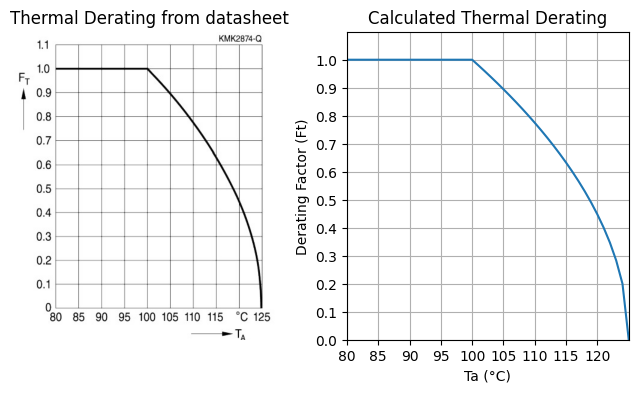

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

img = plt.imread("../01_llc_tank/03_figs/Capa_thermal_derating.jpg")
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title("Thermal Derating from datasheet")


Ta_arr= np.arange(80,125+1,1)
Fa_arr=[]
for Ta in Ta_arr:
    if Ta>100:
        Delta_T= T_max-Ta
        PD_uW_max = Delta_T/R_TH
        Ir_rms_max_Ta=sqrt(PD_uW_max/ESR_u)
        Fa = Ir_rms_max_Ta/Ir_rms_max
        Fa_arr.append(Fa)
    else: 
        Fa_arr.append(1)
        
axes[1].plot(Ta_arr, Fa_arr)

axes[1].set_xlabel("Ta (°C)")
axes[1].set_ylabel("Derating Factor (Ft)")
axes[1].set_title("Calculated Thermal Derating")

axes[1].set_xticks(np.arange(80, 125, 5))
axes[1].set_yticks(np.arange(0, 1.1, 0.1))

axes[1].grid(True)
axes[1].set_ylim([0,1.1])
axes[1].set_xlim([80,125])

### Resonant capacitors configuration

There are two possible configurations for the resonant capacitors:

- All capacitors in parallel:

which is the classic LLC configuration and offers simplicity in layout.
- Dividing the capacitors between the high side and low side:

which helps balance HV+ and HV-.

Below is a simulation of both solutions. We can see that the voltage and current of each capacitor are almost identical in both configurations, and all other voltages and currents are also very similar.

You can donwload the LTSPICE file using this <a src =".\02_simulation\03_Res_capacitor\Comparaison_Res_Capas_Archi.asc">Link</a>.

In [52]:
first_part_path = "./03_figures/"

fig_counter = show_figure_pair_with_captions(
    fig_counter, 
    "Comparaison_Res_Capas_Archi.png",
    "VRMS",
    first_part_path= first_part_path, 
)

## References <a class="title_class" id="title_7"></a>

<a id="referencesID_03_1"></a> [1] Hong Huang, *Designing an LLC Resonant
Half-Bridge Power Converter*. Available: [https://bbs.dianyuan.com/upload/community/2013/12/01/1385867010-65563.pdf](https://bbs.dianyuan.com/upload/community/2013/12/01/1385867010-65563.pdf)

<a id="referencesID_03_2"></a> [2] 
[B40910 Aluminum electrolytic capacitors datasheet](https://product.tdk.com/system/files/dam/doc/product/capacitor/aluminum-electrolytic/hybrid-polymer/data_sheet/20/30/db/aec/b40910.pdf)

<a id="referencesID_03_3"></a> [3] 
[B3267*L Film Capacitors](https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf)


<a id="referencesID_03_4"></a> [4] 
[EMHS Aluminum electrolytic capacitors datasheet](https://www.mouser.fr/datasheet/2/420/Chemi_Con_MHSRA_e-3313675.pdf)

